# Two dimensional unequal sampling generalized prolates

This example is not unlike the 2D example of Bronez. We don't have the data, but here goes.

In [1]:
using FFTW, IterTools, Plots, LinearAlgebra, KrylovKit, FINUFFT
using Slepians

#=
""" 

    dfn(x, y, bet)

The underlying Kernel function, equation 22-23 in Chave

# Arguments
    - `x::Number` 1-dimensional location
    - `y::Number` 1-dimensional location
    - `bet::Number` 1-dimensional bandwidth

# Outputs
    - Kernel evaluated between the two points x, y
"""
function dfn(x, y, bet)
  x == y && return 2*bet
  sin(2 * pi * bet * (x - y))/(pi * (x - y))
end
=#

""" 

    efn(x, y, f)

The FT matrix

# Arguments
    - `x::Vector` d-dimensional location
    - `y::Vector` d-dimensional location
    - `f::Vector` d-dimensional frequency

# Outputs
    - Frequency-dependent kernel evaluated between the two points x, y
"""
function efn(x, y, f)
    x == y && return 1.0
    f == 0.0 && return 1.0
    exp(-2.0im * pi * f * (x - y))
end

# Product of efn and dfn
function bfn(x, y, f, bet)
    efn(x, y, f) * dfn(x, y, bet)
end

bfn (generic function with 1 method)

# Warmup: Missing data problem in 1D

In [2]:
NN = 256
tt = (1.0:NN).^(1.05)

fB = 1.0/2 # *ones(d)
fA = 1.0/8 # *ones(d)

f = 0.0

RA = [dfn(xy..., fA) for xy in IterTools.product(tt, tt)]
RB = [bfn(xy..., f, fB) for xy in IterTools.product(tt, tt)]

neig = geneigsolve(x->(RA*x, RB*x), 256, ishermitian = true, isposdef = true)

([0.24945858039381358], [[66.11004382051424, -147.1539774551788, 15.896520413456082, 101.08251567986592, 51.39807380955196, -37.05734849656574, -76.96476687557889, -48.733057820627785, 12.1396064240293, 56.69670711803339  …  33.93800885141515, 68.12133156845267, 39.09149294091603, -37.10700542571506, -84.68120291450518, -31.20515251681386, 86.31366561576898, 85.73344780462571, -139.0641891162368, 46.53739906803755]], ConvergenceInfo: no converged values after 100 iterations and 3101 applications of the linear map;
norms of residuals are given by (5.851487522957213e-6,).
)

In [16]:
lam_orth, u_orth = gpss_orth(fA, 1, tt, 0.0, beta = fB)

lam, u = gpss(fA, 1, tt, 0.0, beta = fB)

LoadError: [91mUndefVarError: mean not defined[39m

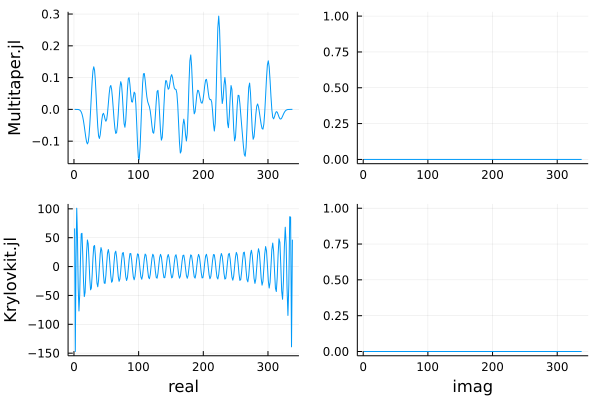

In [4]:
plot(plot(tt, real.(u)), plot(tt, imag.(u)), plot(tt, real.(neig[2][1])), plot(tt, imag.(neig[2][1])),
    layout = (2,2), xlabel = ["" "" "real" "imag"], ylabel = ["Multitaper.jl" "" "Krylovkit.jl" ""], 
    legend = false)

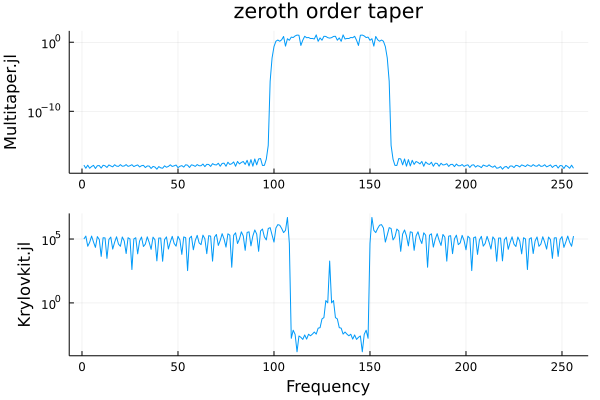

In [5]:
K = 1
w = fA
freqs = LinRange(-0.5, 0.5, NN+1)[1:NN]

ftsleps = mapreduce(k->abs2.(nufft1d3(2*pi*tt, ComplexF64.(u[:,k]), -1, 1e-15, collect(freqs))),hcat, 1:K)

ftsleps2 = abs2.(nufft1d3(2*pi*tt, ComplexF64.(neig[2][1]), -1, 1e-15, collect(freqs)))

plot(plot(ftsleps, yscale = :log10), plot(ftsleps2, yscale = :log10), layout = (2,1), legend = false,
    title = ["zeroth order taper" ""], xlabel = ["" "Frequency"], ylabel = ["Multitaper.jl" "Krylovkit.jl"])

# Warmup: Missing data problem in 2D

This is like the data in the Chave paper, only 2D. Gaps. 

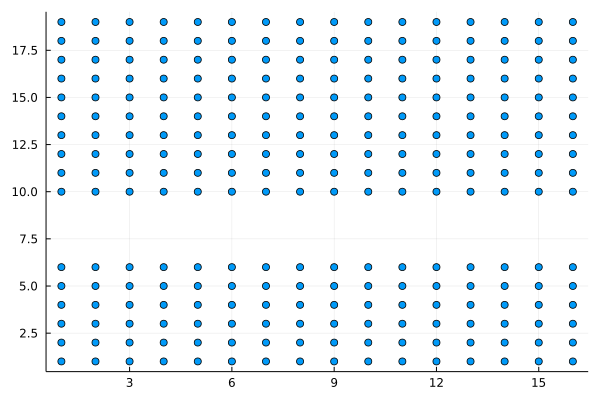

In [6]:
N1 = 16
N2 = 16
t1 = collect(1:N1)
t2 = collect(1:(N2 + 3))[vcat(collect(1:6), collect(10:19))]

mdpts = [(r,t) for r in t1 for t in t2]
mdlocs = [[r,t] for r in t1 for t in t2]

scatter(mdpts, legend = false)

In [7]:
fB = 1.0/2 
fA = 1.0/8 

RA = [dfn(xy..., fA) for xy in IterTools.product(mdlocs, mdlocs)]
RB = [dfn(xy..., fB) for xy in IterTools.product(mdlocs, mdlocs)]

gs = geneigsolve(x->(RA*x, RB*x), 256, ishermitian = true, isposdef = true) #, howmany = 1, which = :LM, issymmetric = true, T = ComplexF64)

([0.8481116941241265], [[1467.8739503970914, -1058.5429897046413, 223.83441564986336, 801.6480311278517, 421.52919095890644, -126.54755395369172, 654.4296495009798, 568.3104913529883, 232.36398534422383, -84.13143028534975  …  685.4778810114193, 573.9804883548906, 217.7533942355201, -99.95848971071938, 3.6801907881944014, 464.44093593327375, 744.226062871947, 121.99061406780558, -1087.2439415157385, 1449.0424883640183]], ConvergenceInfo: no converged values after 100 iterations and 3101 applications of the linear map;
norms of residuals are given by (2.1017983141941324e-5,).
)

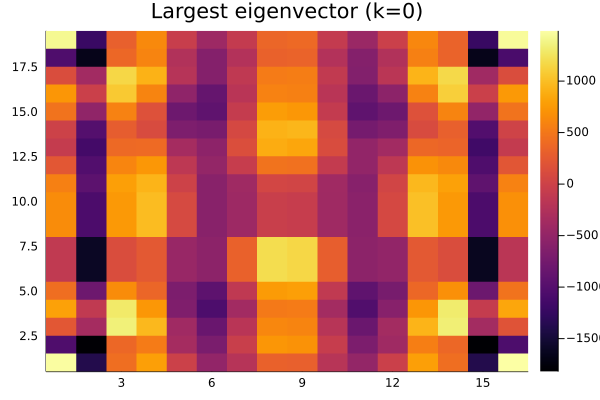

In [8]:
heatmap(t1, t2, reshape(gs[2][1], (16, 16)), title = "Largest eigenvector (k=0)")

# General problem: Unequal spacing in array

Here is an array similar to the example in the original Bronez paper. 

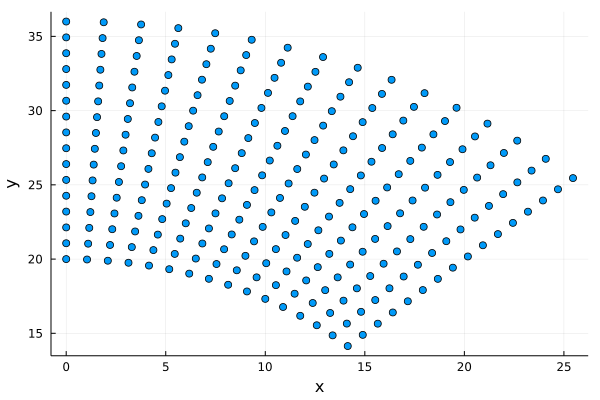

In [9]:
# Set up the array
N1 = 16
N2 = 16

# generate 32 ocncentric circles
rad = collect(LinRange(20,36.0,N1))
thet = collect(LinRange(0.0,45,N2)*pi/180)

pts1 = [(r*sin(t), r*cos(t)) for r in rad for t in thet]

locs1 = [[r*sin(t), r*cos(t)] for r in rad for t in thet]

scatter(pts1, legend = false, xlabel="x", ylabel="y")

In [10]:
# Get the RA and RB matrices, simplifications are provided by Chave, 2020 p 8
d = 2

fB = 1.0/2 # *ones(d)
fA = 1.0/8 # *ones(d)

f = 0.1

RA = [dfn(xy..., fA) for xy in IterTools.product(locs1, locs1)]
RB = [bfn(xy..., [fB, f]) for xy in IterTools.product(locs1, locs1)]

neig = geneigsolve(x->(RA*x, RB*x), 256, ishermitian = true, isposdef = true) #, howmany = 1, which = :LM, issymmetric = true, T = ComplexF64)

LoadError: [91mMethodError: no method matching bfn(::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,1})[39m
[91m[0mClosest candidates are:[39m
[91m[0m  bfn(::Any, ::Any, ::Any, [91m::Any[39m) at In[1]:46[39m

In [11]:
xx = hcat(locs1...)

2×256 Array{Float64,2}:
  0.0   1.04672   2.09057   3.12869  …  21.1603  22.6555  24.0887  25.4558
 20.0  19.9726   19.8904   19.7538      29.1246  27.9773  26.7532  25.4558

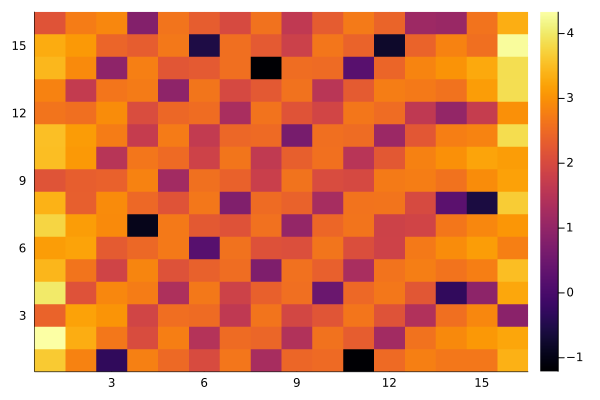

In [12]:
# This is deformed though, so it is hard to visualize with a heatmap
heatmap(log10.(abs2.(reshape(neig[2][1], (16, 16)))))

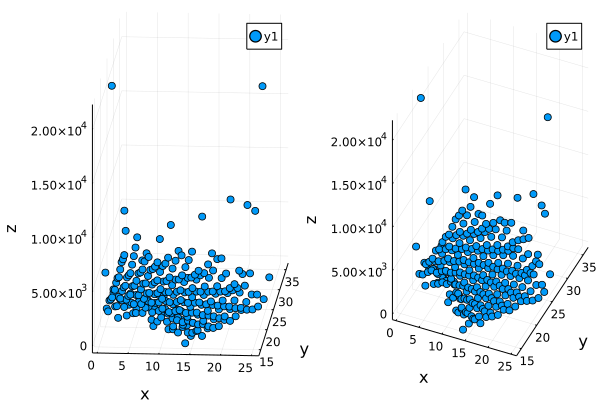

In [13]:
# could do a mesh too
pa = scatter(xx[1,:], xx[2,:], abs2.(neig[2][1]), camera = (10, 35), xlabel = "x", ylabel = "y", zlabel="z")

pb = scatter(xx[1,:], xx[2,:], abs2.(neig[2][1]), camera = (30, 50), xlabel = "x", ylabel = "y", zlabel="z")

plot(pa, pb, layout = (1,2))

In [14]:
freqs1 = LinRange(-1, 1.0, N1)
freqs2 = LinRange(-1, 1.0, N2)

ff = vcat([[xy[1] xy[2]] for xy in IterTools.product(freqs1, freqs2)][:]...)

XX = abs2.(nufft2d1(2*pi*(xx[1,:] .- 12.5)/25., 2*pi*(xx[2,:] .- 12.5)/25., 
        ComplexF64.(neig[2][1]), -1, 1e-15, 2*N1, 2*N2))

#=
# Inputs to nufft2d3 from FINUFFT
nufft2d3(xj      :: Array{Float64}, 
         yj      :: Array{Float64},
         cj      :: Array{ComplexF64}, 
         iflag   :: Integer, 
         eps     :: Float64,
         sk      :: Array{Float64},
         tk      :: Array{Float64}
         [, opts :: nufft_opts]
        ) -> Array{ComplexF64}
=#

#=
# Inputs to nufft2d1 from FINUFFT
nufft2d1(xj      :: Array{Float64}, 
         yj      :: Array{Float64}, 
         cj      :: Array{ComplexF64}, 
         iflag   :: Integer, 
         eps     :: Float64,
         ms      :: Integer,
         mt      :: Integer,
         [, opts :: nufft_opts]
        ) -> Array{ComplexF64}=#

32×32 Array{Float64,2}:
      1.21595e5      1.74066e5  …       5.2684e5       3.7396e5
      2.37316e5      3.07795e5          3.44474e5      1.60593e5
      1.05904e5      4.31327e5          1.27599e5  54382.2
  90279.1            8.61283e5          3.70691e5      2.96939e5
      5.22381e5      6.07121e5          1.59484e5      4.22987e5
 232040.0        62274.6        …       1.38901e5     39.9335
      3.84378e5  42592.2            19534.2            2.26628e5
  22851.3        88481.2                1.06038e5      2.2568e5
  31929.5            2.37972e5      42536.0        70463.8
      2.62074e5  17482.7            50243.1        20745.8
      5.14781e5      2.33647e5  …       1.28633e5  51389.4
  47974.3        72794.0                1.99558e5  80503.0
      3.18039e5   3348.78            3246.92           2.30741e5
      ⋮                         ⋱       ⋮          
  45774.4            2.30741e5  …   11836.3         3348.78
  89242.8        80503.0                1.70291e5  727

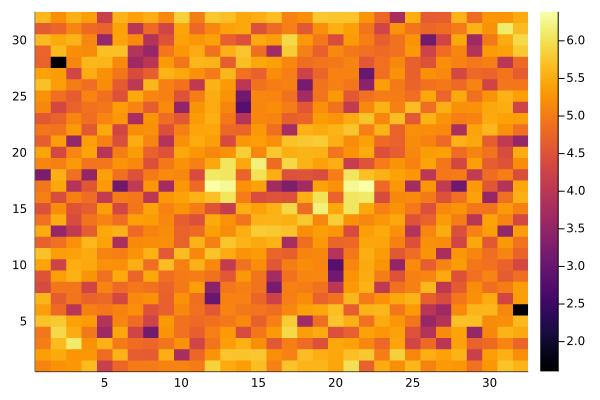

In [15]:
heatmap(log10.(XX))